# **Module 5 - Essentials**

Here, I will attempt to explore the jeopardy dataset with a SVM model and Keras Text Classifier and create a binary classifer for the value level for each question.

In [14]:
#installing nltk packages onto system
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Installing Libraries

In [41]:
import pandas as pd
import json
import matplotlib.pyplot as plt
#preprocessing libraries
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer #not needed as TfidfVectorizer is being used.
from nltk.corpus import stopwords
from string import punctuation
#libraries for the models and SVM
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
#libraries for the Keras Model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [4]:
jepordarydf = pd.read_json('jeopardy.json')

In [5]:
#discovering how many null values there are
jepordarydf.isnull().sum()

,0
category,0
air_date,0
question,0
value,3634
answer,0
round,0
show_number,0


In [6]:
#removing the null values as leaving them or replacing them with 'None' would have interfered with the models' performance.
jepordarydf = jepordarydf.dropna()
jepordarydf.isnull().sum()

,0
category,0
air_date,0
question,0
value,0
answer,0
round,0
show_number,0


In [7]:
#getting a sense of the data in the df
jepordarydf

,category,air_date,question,value,answer,round,show_number
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,Jeopardy!,4680
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,$200,Arizona,Jeopardy!,4680
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",$200,McDonald\'s,Jeopardy!,4680
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",$200,John Adams,Jeopardy!,4680
...,...,...,...,...,...,...,...
216924,OFF-BROADWAY,2006-05-11,'In 2006 the cast of this long-running hit emb...,$2000,Stomp,Double Jeopardy!,4999
216925,RIDDLE ME THIS,2006-05-11,'This Puccini opera turns on the solution to 3...,$2000,Turandot,Double Jeopardy!,4999
216926,"""T"" BIRDS",2006-05-11,'In North America this term is properly applie...,$2000,a titmouse,Double Jeopardy!,4999
216927,AUTHORS IN THEIR YOUTH,2006-05-11,"'In Penny Lane, where this ""Hellraiser"" grew u...",$2000,Clive Barker,Double Jeopardy!,4999


In [8]:
#tokenizing the 'question' column of the jeopardy dataset.
questiontoken = jepordarydf['question'].apply(word_tokenize)
#taking a look at the newly tokenized questions
questiontoken.head(2)

,question
0,"['For, the, last, 8, years, of, his, life, ,, ..."
1,"['No, ., 2, :, 1912, Olympian, ;, football, st..."


In [9]:
#defining stopwords to drop commonly used words from the question column.
english_stopwords = stopwords.words('english') + list(punctuation) + ["'", '``', ',', ':', '/', '&', "''"]

In [10]:
#creating for loop to make a filtered list of questions without the stopwords
stopped_questions=[]
for token in questiontoken:
  filter = [word for word in token if word.lower() not in english_stopwords]
  stopped_questions.append(filter)
#stopped_questions = [x for x in questiontoken if not x in english_stopwords]

In [11]:
#showing the list entry in the stopped_questions list
stopped_questions[0]

["'For",
 'last',
 '8',
 'years',
 'life',
 'Galileo',
 'house',
 'arrest',
 'espousing',
 'man',
 "'s",
 'theory']

In [12]:
#trying to set up parts of speech for lemmization
pos_tagged = questiontoken.apply(pos_tag)

In [17]:
pos_tagged.head(2)

,question
0,"[('For, ''), (the, DT), (last, JJ), (8, CD), (..."
1,"[('No, POS), (., .), (2, CD), (:, :), (1912, C..."


In [15]:
#attempt to set up the lemmatizer
lemmatizer = WordNetLemmatizer()

#attempted to use the apply function again using lambda to lemmatize the data
lematized = questiontoken.apply(lambda eachword: [lemmatizer.lemmatize(word) for word in eachword])

In [16]:
lematized.head(2)

,question
0,"['For, the, last, 8, year, of, his, life, ,, G..."
1,"['No, ., 2, :, 1912, Olympian, ;, football, st..."


Cleaning the Data & Creating the Binary Column

In [19]:
#stripping the 'vallue' column of its dollarsigns and commas and making it an 'int' type so I can turn it into a binary value later.
jepordarydf['value']=(jepordarydf['value'].str.replace('$', '').str.replace(',','').astype(int))

In [20]:
#upon creating the 'valuebinary' column, I noticed that higher tier rounds like double and final jeopardy typically contain questions with higher difficulty.
#thus setting a target above or below a certain desired value may not correctly categorize the correct difficulty for a question.
def settingvalue(number):
  value = number['value']
  rounds = number['round']
#defining a high value for the jeopardy round as any value above $600
  if rounds == 'Jeopardy!':
    if value > 600:
      return 1
    else:
      return 0
  #defining a high value for the double jeopardy round as any value above $1000
  elif rounds == 'Double Jeopardy!':
    if value > 1000:
      return 1
    else:
      return 0
  #NOTE: I didn't include other categories like final jeopardy or tiebreaker as these were rows that had to be dropped as it contained null values that would have otherwise inferred with the model predictions.

In [21]:
#making valuebinary column using the function since categories like double and final jeopardy have a higher starting difficulty than normal jeopardy.
jepordarydf['valuebinary'] = jepordarydf.apply(settingvalue, axis=1)

In [22]:
#checking the value counts.
jepordarydf['valuebinary'].value_counts()

,count
valuebinary,
0,148705
1,64591


Beginning Model Creation

In [23]:
#due to the size of the dataset, I will only explore the first 10,000 rows
#passing the newly lemmatized data to improve model performance.
X = lematized[0:10000]
y = jepordarydf['valuebinary'][0:10000]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
#using TfidfVectorizer to turn the question column into a numerical format for the model to be able to use the data.
tf = TfidfVectorizer(stop_words='english')
X_train_scaled = tf.fit_transform(X_train.astype(str))
X_test_scaled = tf.transform(X_test.astype(str))

Support Vector Model

In [26]:
svmclass = SVC(kernel='linear', C=1.0, random_state=42)
svmclass.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=42)

In [27]:
y_pred = svmclass.predict(X_test_scaled)
print(f'Accuracy:{accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))

Accuracy:0.68
              precision    recall  f1-score   support

           0       0.70      0.94      0.80      1377
           1       0.45      0.11      0.18       623

    accuracy                           0.68      2000
   macro avg       0.58      0.52      0.49      2000
weighted avg       0.62      0.68      0.61      2000



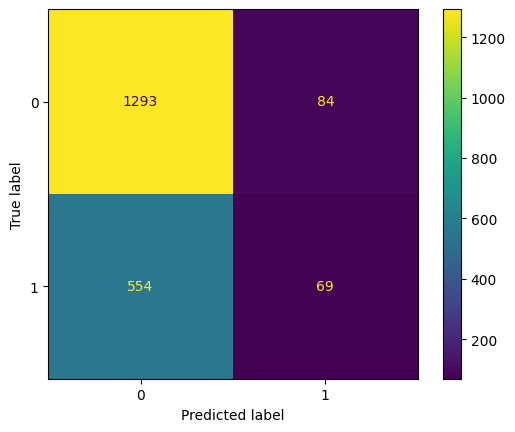

In [46]:
#creating a confusion matrix for SVM Model using the y_test and y_pred data
CFM = confusion_matrix(y_test, y_pred)
#plotting the confusion matrix
cfmdis = ConfusionMatrixDisplay(confusion_matrix=CFM)
cfmdis.plot()
plt.show()

In [47]:
#SVM False Negative Rate
false_neg_SVM = round(CFM[0,1]/(CFM[0,1]+CFM[1,1]),6)
print('False Negative Rate:', false_neg_SVM)

False Negative Rate: 0.54902


The SVM model appears to have a accuracy rate of about 68% with a false negative rate or a miss rate of 54%. This performance could be due to the nature of the complexity of this dataset.

Keras Text Classifier Model

In [28]:
#I will use the previously split data in this model.
#setting up the keras model.
kerasmodel = Sequential()
#the number 64 was used in this dense layer as it was said to be a common number to use in tensorflow's tutorial
kerasmodel.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
#here I used 'sigmoid' as I wish to use binary classification in this model.
kerasmodel.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
#since I am trying to explore a binary text classification, for loss I chose 'binary_crossentropy' and accuracy metrics as it is more geared toward binary classification.
kerasmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
#Model Fitting
#Initially, I had epochs set to 100 and batch_size at 8. However, do to the size of the section of data, that caused the model process to become very lengthy.
#As a result, I reduced these values to epoch 20 and batch_size 32. This allows the samples / batch_size to be bigger and for the model to only cycle 20 times instead of 100.
history = kerasmodel.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

In [31]:
#looking at the model's preformance (loss and accuracy levels)
loss, accuracy = kerasmodel.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5946 - loss: 1.8500
Test Loss: 1.8863, Test Accuracy: 0.5800


One observation: when initally running both of these models, I used jepodarydf['questions'] as the 'X' variable to see if the models were correctly constructed. However, when I went back to using the lemmatized data in the models in effort to improve preformance, I noticed that the models' performance actually decreased a bit.

**I've included the old code I ran before as a reference to what I saw, please disregard otherwise.**

In comparison to the Naive Bayes model, I previously constructed in the basics project-- these models, SVM and Keras seem to perform about the same. With around 68 - 70% accuracy. Additionally, when comparing the SVM model to the Naives Bayes model, I saw that the SVM model may have preformed better as it had a much lower miss rate of 54% compared to the Naives Bayes model of 93%.

Old SVM Model with the Un-lemmatized Data

In [32]:
#due to the size of the dataset, I will only explore the first 10,000 rows
#passing the newly lemmatized data to improve model performance.
Xvalue = jepordarydf['question'][0:10000]
#y = jepordarydf['valuebinary'][0:10000]
X_trainold, X_testold, y_trainold, y_testold = train_test_split(Xvalue, y, test_size=0.2, random_state=42)

In [33]:
#using TfidfVectorizer to turn the question column into a numerical format for the model to be able to use the data.
tf = TfidfVectorizer(stop_words='english')
X_train_scaledold = tf.fit_transform(X_trainold.astype(str))
X_test_scaledold = tf.transform(X_testold.astype(str))

In [34]:
svmclassold = SVC(kernel='linear', C=1.0, random_state=42)
svmclassold.fit(X_train_scaledold, y_trainold)

SVC(kernel='linear', random_state=42)

In [35]:
y_predold = svmclassold.predict(X_test_scaledold)
print(f'Accuracy:{accuracy_score(y_testold, y_predold):.2f}')
print(classification_report(y_testold, y_predold))

Accuracy:0.67
              precision    recall  f1-score   support

           0       0.70      0.93      0.80      1377
           1       0.41      0.10      0.17       623

    accuracy                           0.67      2000
   macro avg       0.55      0.52      0.48      2000
weighted avg       0.61      0.67      0.60      2000



Old Keras Model Code with the Un-lemmatized Data

In [36]:
kerasmodelold = Sequential()
kerasmodelold.add(Dense(64, activation='relu', input_shape=(X_train_scaledold.shape[1],)))
kerasmodelold.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
#since I am trying to explore a binary text classification, for loss I chose 'binary_crossentropy' and accuracy metrics as it is more geared toward binary classification.
kerasmodelold.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
#Old Keras Model Fitting
#Initially, I had epochs set to 100 and batch_size at 8. However, do to the size of the section of data, that caused the model process to become very lengthy.
#As a result, I reduced these values to
historyold = kerasmodelold.fit(X_train_scaledold, y_trainold, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

In [39]:
lossold, accuracyold = kerasmodelold.evaluate(X_test_scaledold, y_testold)
print(f"Old Test Loss: {lossold:.4f}, Old Test Accuracy: {accuracyold:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5959 - loss: 1.9280
Old Test Loss: 1.9477, OldTest Accuracy: 0.5805
